In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
from datetime import datetime
import time
from sklearn import metrics
from sklearn.metrics import mean_squared_error,log_loss
from sklearn.model_selection import KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_rows=500
pd.options.display.max_columns=100
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/xente-challenge/SampleSubmission.csv
/kaggle/input/xente-challenge/train.csv
/kaggle/input/xente-challenge/test.csv


In [2]:
train=pd.read_csv('/kaggle/input/xente-challenge/train.csv',parse_dates=['date'])
test=pd.read_csv('/kaggle/input/xente-challenge/test.csv',parse_dates=['date'])
sub_df=pd.read_csv('/kaggle/input/xente-challenge/SampleSubmission.csv')

In [3]:
train.head(2)

,ID,area,date,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,...,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,population_density,precipitation
0,0_2000-04-01,0,2000-04-01,25.447,5.296,0.003688,1250.622712,0.0,-178.916305,1250.622712,...,0.0,0.350169,0.0,0.649524,0.0,0.000307,0.0,0.0,2.214262,0.198996
1,1_2000-04-01,1,2000-04-01,25.669,5.293,0.000000,1238.019166,0.0,-150.779947,1238.019166,...,0.0,0.429049,0.0,0.570644,0.0,0.000307,0.0,0.0,3.833042,0.188071


In [6]:
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year
train['dow'] = train.date.dt.dayofweek
train['woy'] = train.date.dt.weekofyear
train['quarter'] = train.date.dt.quarter

In [7]:
test['month'] = test.date.dt.month
test['year'] = test.date.dt.year
test['dow'] = test.date.dt.dayofweek
test['woy'] = test.date.dt.weekofyear
test['quarter'] = test.date.dt.quarter

In [8]:
train_df=train
test_df=test

In [9]:
split=train_df.shape[0]
data=pd.concat([train_df,test_df])

In [10]:

data['mean_precipitation_per_month'] = data['month'].map(data.groupby('month').mean()['precipitation'])
data['std_precipitation_per_month'] = data['month'].map(data.groupby('month').std()['precipitation'])
data['max_precipitationr_per_rider'] = data['month'].map(data.groupby('month').max()['precipitation'])
data['min_precipitation_per_month'] = data['month'].map(data.groupby('month').min()['precipitation'])

data['mean_population_density_per_month'] = data['month'].map(data.groupby('month').mean()['population_density'])
data['std_population_density_per_month'] = data['month'].map(data.groupby('month').std()['population_density'])
data['max_population_density_per_month'] = data['month'].map(data.groupby('month').max()['population_density'])
data['min_population_density_per_month'] = data['month'].map(data.groupby('month').min()['population_density'])



data['mean_climate_vs_per_month'] = data['month'].map(data.groupby('month').mean()['climate_vs'])
data['std_climate_vsper_month'] = data['month'].map(data.groupby('month').std()['climate_vs'])
data['max_climate_vs_per_month'] = data['month'].map(data.groupby('month').max()['climate_vs'])
data['min_climate_vs_per_month'] = data['month'].map(data.groupby('month').min()['climate_vs'])



data['mean_climate_vpdper_month'] = data['month'].map(data.groupby('month').mean()['climate_vpd'])
data['std_climate_vpd_per_month'] = data['month'].map(data.groupby('month').std()['climate_vpd'])
data['max_climate_vpd_per_month'] = data['month'].map(data.groupby('month').max()['climate_vpd'])
data['min_climate_vpdy_per_month'] = data['month'].map(data.groupby('month').min()['climate_vpd'])


data['mean_climate_vapy_per_month'] = data['month'].map(data.groupby('month').mean()['climate_vap'])
data['std_climate_vapy_per_month'] = data['month'].map(data.groupby('month').std()['climate_vap'])
data['max_climate_vap_per_month'] = data['month'].map(data.groupby('month').max()['climate_vap'])
data['min_climate_vapper_month'] = data['month'].map(data.groupby('month').min()['climate_vap'])


data['mean_climate_tmmx_per_month'] = data['month'].map(data.groupby('month').mean()['climate_tmmx'])
data['std_climate_tmmx_per_month'] = data['month'].map(data.groupby('month').std()['climate_tmmx'])
data['max_climate_tmmx_per_month'] = data['month'].map(data.groupby('month').max()['climate_tmmx'])
data['min_climate_tmmx_per_month'] = data['month'].map(data.groupby('month').min()['climate_tmmx'])




In [11]:
i_cols=['landcover_0','landcover_1','landcover_2','landcover_3','landcover_4','landcover_5','landcover_6','landcover_7','landcover_8','climate_pr','climate_ro','climate_swe']

In [12]:

for col in i_cols:  
    fq_encode = data[col].value_counts().to_dict()   
    data[col+'_fq_enc'] = data[col].map(fq_encode)

In [13]:
i_cols2=['climate_aet','climate_pdsi','climate_pet','precipitation','population_density','climate_vs','climate_vpd']

In [14]:
i_cols3=['climate_aet','climate_pdsi','climate_pet','precipitation','population_density','climate_vs','climate_vpd']

In [15]:
for col in i_cols3:
    for agg_type in ['mean', 'std','max','min']:
        new_col_name = col+'woy'+agg_type
        temp_df =  data.groupby([col])['woy'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
    
        data[new_col_name] =  data[col].map(temp_df)

In [18]:
step = 0.2
to_bin = lambda x: np.floor(x / step) * step
data["latbin"] = data.lat.map(to_bin)
data["lonbin"] = data.lon.map(to_bin)
groups = data.groupby(("latbin", "lonbin"))

In [19]:
data['total_landcover']=data['landcover_0']+data['landcover_1']+data['landcover_2']+data['landcover_3']+data['landcover_4']+data['landcover_5']+data['landcover_6']+data['landcover_7']+data['landcover_8']

In [20]:
for col in i_cols2:  
    fq_encode = data[col].value_counts().to_dict()   
    data[col+'_fq_enc'] = data[col].map(fq_encode)

In [21]:
for col in i_cols3:  
    fq_encode = data[col].value_counts().to_dict()   
    data[col+'_fq_enc'] = data[col].map(fq_encode)

In [22]:
data['climate_range']=data['climate_tmmx']-data['climate_tmmn']

In [23]:
train_df=data[:split]
test_df=data[split:]

In [24]:
train_df.head(2)

,ID,area,date,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,population_density,precipitation,month,year,dow,woy,quarter,mean_precipitation_per_month,std_precipitation_per_month,max_precipitationr_per_rider,min_precipitation_per_month,mean_population_density_per_month,std_population_density_per_month,max_population_density_per_month,min_population_density_per_month,mean_climate_vs_per_month,std_climate_vsper_month,max_climate_vs_per_month,min_climate_vs_per_month,mean_climate_vpdper_month,...,landcover_1_fq_enc,landcover_2_fq_enc,landcover_3_fq_enc,landcover_4_fq_enc,landcover_5_fq_enc,landcover_6_fq_enc,landcover_7_fq_enc,landcover_8_fq_enc,climate_pr_fq_enc,climate_ro_fq_enc,climate_swe_fq_enc,climate_aetwoymean,climate_aetwoystd,climate_aetwoymax,climate_aetwoymin,climate_pdsiwoymean,climate_pdsiwoystd,climate_pdsiwoymax,climate_pdsiwoymin,climate_petwoymean,climate_petwoystd,climate_petwoymax,climate_petwoymin,precipitationwoymean,precipitationwoystd,precipitationwoymax,precipitationwoymin,population_densitywoymean,population_densitywoystd,population_densitywoymax,population_densitywoymin,climate_vswoymean,climate_vswoystd,climate_vswoymax,climate_vswoymin,climate_vpdwoymean,climate_vpdwoystd,climate_vpdwoymax,climate_vpdwoymin,latbin,lonbin,total_landcover,climate_aet_fq_enc,climate_pdsi_fq_enc,climate_pet_fq_enc,precipitation_fq_enc,population_density_fq_enc,climate_vs_fq_enc,climate_vpd_fq_enc,climate_range
0,0_2000-04-01,0,2000-04-01,25.447,5.296,0.003688,1250.622712,0.0,-178.916305,1250.622712,158.387765,8.000000,498.913776,2143.430034,0.0,206.935453,323.873675,2508.795159,115.989282,129.825024,590.564102,0.0,0.0,0.350169,0.0,0.649524,0.0,0.000307,0.0,0.0,2.214262,0.198996,4,2000,5,13,2,0.20762,0.112193,1.164015,0.002402,30.917652,178.748387,9514.00427,0.0,154.932535,46.818711,333.718147,71.575362,81.590338,...,753615,10,763831,10,743867,259,750435,600016,1,5699,764196,13.0,NaN,13,13,13.0,NaN,13,13,13.0,NaN,13,13,13.0,NaN,13,13,26.105263,15.208884,53.0,1.0,13.0,NaN,13,13,13.0,NaN,13,13,25.4,5.2,1.0,1,1,1,1,57.0,1,1,116.938223
1,1_2000-04-01,1,2000-04-01,25.669,5.293,0.000000,1238.019166,0.0,-150.779947,1238.019166,164.645065,8.104576,590.346191,2132.253953,0.0,204.835170,321.838884,2500.432319,112.619789,129.471370,611.544277,0.0,0.0,0.429049,0.0,0.570644,0.0,0.000307,0.0,0.0,3.833042,0.188071,4,2000,5,13,2,0.20762,0.112193,1.164015,0.002402,30.917652,178.748387,9514.00427,0.0,154.932535,46.818711,333.718147,71.575362,81.590338,...,753615,10,763831,10,743867,93,750435,600016,1,1,764196,13.0,NaN,13,13,13.0,NaN,13,13,13.0,NaN,13,13,13.0,NaN,13,13,26.105263,15.208884,53.0,1.0,13.0,NaN,13,13,13.0,NaN,13,13,25.6,5.2,1.0,1,1,1,1,57.0,1,1,117.003713


In [25]:

param = {'num_leaves': 156,
     'min_data_in_leaf': 50, 
     'objective':'regression',
     'max_depth': 18,
     'learning_rate': 0.006,
     "boosting": "gbdt",
     "feature_fraction": 0.2,
     "bagging_freq": 0,
     "bagging_fraction": 1.0 ,
     "bagging_seed": 4,
     "metric": 'rmse',
     "verbosity": 1,
     "verbose_eval": False
    }
features = [c for c in train_df.columns if c not in ['date','ID','burn_area']]
target = train_df['burn_area']

folds = KFold(n_splits=10, shuffle=True, random_state=15)
oof_lgb = np.zeros(len(train_df))
predictions_lgb = np.zeros(len(test_df))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 13000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 500)
    oof_lgb[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteratio)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions_lgb += clf.predict(test_df[features], num_iteration=clf.best_iteratio) / folds.n_splits
oof_lgb[oof_lgb < 0] = 0
print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)**0.5))


fold n°0
Training until validation scores don't improve for 500 rounds
[100]	training's rmse: 0.0467463	valid_1's rmse: 0.0465449
[200]	training's rmse: 0.0389189	valid_1's rmse: 0.0391018
[300]	training's rmse: 0.0345334	valid_1's rmse: 0.0350492
[400]	training's rmse: 0.0315907	valid_1's rmse: 0.0324134
[500]	training's rmse: 0.0295781	valid_1's rmse: 0.0306478
[600]	training's rmse: 0.0281408	valid_1's rmse: 0.0294173
[700]	training's rmse: 0.026978	valid_1's rmse: 0.0284559
[800]	training's rmse: 0.0260501	valid_1's rmse: 0.0277021
[900]	training's rmse: 0.0252826	valid_1's rmse: 0.0271028
[1000]	training's rmse: 0.0245977	valid_1's rmse: 0.0265647
[1100]	training's rmse: 0.0240233	valid_1's rmse: 0.0261391
[1200]	training's rmse: 0.0235369	valid_1's rmse: 0.0257836
[1300]	training's rmse: 0.023086	valid_1's rmse: 0.0254643
[1400]	training's rmse: 0.0226868	valid_1's rmse: 0.0251869
[1500]	training's rmse: 0.0223182	valid_1's rmse: 0.0249364
[1600]	training's rmse: 0.0219729	valid_

[1200]	training's rmse: 0.0234963	valid_1's rmse: 0.0259633
[1300]	training's rmse: 0.0230489	valid_1's rmse: 0.0256356
[1400]	training's rmse: 0.0226408	valid_1's rmse: 0.0253432
[1500]	training's rmse: 0.022271	valid_1's rmse: 0.0250834
[1600]	training's rmse: 0.0219259	valid_1's rmse: 0.0248433
[1700]	training's rmse: 0.0216054	valid_1's rmse: 0.0246166
[1800]	training's rmse: 0.0213199	valid_1's rmse: 0.0244246
[1900]	training's rmse: 0.0210382	valid_1's rmse: 0.0242349
[2000]	training's rmse: 0.0207802	valid_1's rmse: 0.0240603
[2100]	training's rmse: 0.0205288	valid_1's rmse: 0.0238968
[2200]	training's rmse: 0.0203112	valid_1's rmse: 0.0237618
[2300]	training's rmse: 0.0200999	valid_1's rmse: 0.0236313
[2400]	training's rmse: 0.0198999	valid_1's rmse: 0.0235098
[2500]	training's rmse: 0.0197118	valid_1's rmse: 0.0233978
[2600]	training's rmse: 0.0195334	valid_1's rmse: 0.0232952
[2700]	training's rmse: 0.0193582	valid_1's rmse: 0.0231941
[2800]	training's rmse: 0.0191837	valid_1

[2400]	training's rmse: 0.01983	valid_1's rmse: 0.0234874
[2500]	training's rmse: 0.019637	valid_1's rmse: 0.0233757
[2600]	training's rmse: 0.019452	valid_1's rmse: 0.0232734
[2700]	training's rmse: 0.019277	valid_1's rmse: 0.0231734
[2800]	training's rmse: 0.0191014	valid_1's rmse: 0.0230732
[2900]	training's rmse: 0.0189274	valid_1's rmse: 0.0229767
[3000]	training's rmse: 0.0187633	valid_1's rmse: 0.0228881
[3100]	training's rmse: 0.0186037	valid_1's rmse: 0.0228031
[3200]	training's rmse: 0.0184415	valid_1's rmse: 0.0227145
[3300]	training's rmse: 0.0182883	valid_1's rmse: 0.0226351
[3400]	training's rmse: 0.018134	valid_1's rmse: 0.0225518
[3500]	training's rmse: 0.0179851	valid_1's rmse: 0.0224754
[3600]	training's rmse: 0.0178481	valid_1's rmse: 0.0224071
[3700]	training's rmse: 0.0177165	valid_1's rmse: 0.0223421
[3800]	training's rmse: 0.0175918	valid_1's rmse: 0.0222839
[3900]	training's rmse: 0.0174739	valid_1's rmse: 0.0222293
[4000]	training's rmse: 0.0173559	valid_1's rm

In [26]:
sub=test_df[["ID"]]
sub['target'] = predictions_lgb
sub.to_csv('postchallenge.csv', index = False)

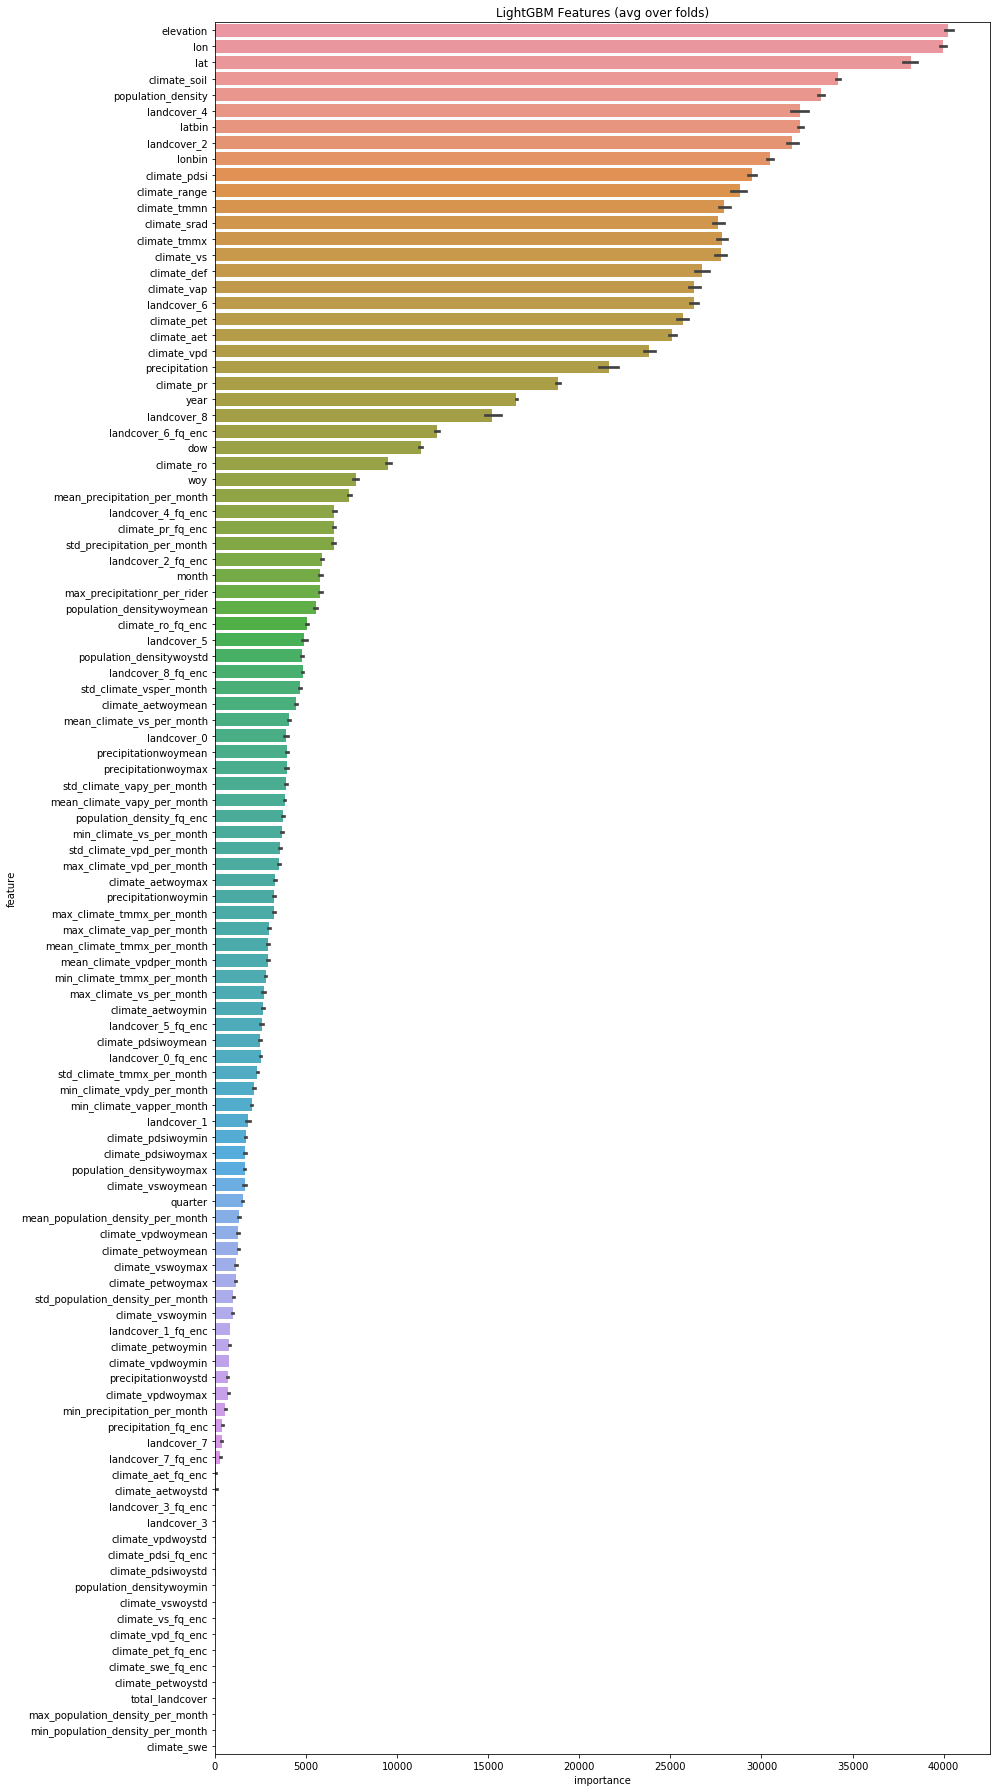

In [27]:

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:30].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')